<h1>Introduction</h1>
On this notebook , i'm going to solve a classical regression problem from kaggle , where i have learned and used 
LGBM adn Xgboost classifiers  .
for more details , check out this <a href = "https://www.kaggle.com/c/flight-delays-fall-2018" >https://www.kaggle.com/c/flight-delays-fall-2018</a>


<h2>Importants Libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

<h2> Import Data</h2>

In [2]:
train_df = pd.read_csv('/flight_delays_train.csv')
test_df = pd.read_csv('/flight_delays_test.csv')
submission  = pd.read_csv('//sample_submission.csv')

train_df.head(10)



,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,N
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,N
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,N
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,N


<h2>Data Exploration</h2>

In [3]:
# i'll rename the target column 
train_df = train_df.rename(columns = {"dep_delayed_15min" : "target"})
train_df = train_df.replace({"target" : {"N" : 0 , "Y": 1 }})

train_df.head(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,target
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,0
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,0
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,0
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,0
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,0


In [4]:
SEED = 42
train_df.info(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
 8   target         100000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


In [5]:
# Check for duplicates
train_df.duplicated().any()


False

In [6]:
#categorical data
train_df.describe(include=['O'])

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest
count,100000,100000,100000,100000,100000,100000
unique,12,31,7,22,289,289
top,c-8,c-1,c-4,WN,ATL,ATL
freq,8830,3399,14736,15082,5834,5795


In [7]:
#numerical data
train_df.describe()

,DepTime,Distance,target
count,100000.000000,100000.00000,100000.00000
mean,1341.523880,729.39716,0.19044
std,476.378445,574.61686,0.39265
min,1.000000,30.00000,0.00000
25%,931.000000,317.00000,0.00000
50%,1330.000000,575.00000,0.00000
75%,1733.000000,957.00000,0.00000
max,2534.000000,4962.00000,1.00000


<h2>Data Preprocessing</h2>

In [8]:
#encoding categorical data 
cat_data  = train_df.select_dtypes(include=['object']).columns.tolist()
#for the dayOfmonth and the dayOfweek we will use find and replace approach 
#we will do thaat manualy 
Month_Mapp = {x : int(x.split("-")[1]) for x in train_df['Month'].unique()}
DayOfMonth_Mapp = {x : int(x.split("-")[1]) for x in train_df['DayofMonth'].unique()}
DayOfWeek_Mapp = {x : int(x.split("-")[1]) for x in train_df['DayOfWeek'].unique()}
print(f"Month Mapping = {Month_Mapp}")
print(f"DayOfMonth Mapping = {DayOfMonth_Mapp}")
print(f"DayOfWeek Mapping = {DayOfWeek_Mapp}")






Month Mapping = {'c-8': 8, 'c-4': 4, 'c-9': 9, 'c-11': 11, 'c-10': 10, 'c-1': 1, 'c-7': 7, 'c-6': 6, 'c-5': 5, 'c-3': 3, 'c-12': 12, 'c-2': 2}
DayOfMonth Mapping = {'c-21': 21, 'c-20': 20, 'c-2': 2, 'c-25': 25, 'c-7': 7, 'c-3': 3, 'c-27': 27, 'c-29': 29, 'c-28': 28, 'c-5': 5, 'c-6': 6, 'c-10': 10, 'c-19': 19, 'c-26': 26, 'c-14': 14, 'c-22': 22, 'c-9': 9, 'c-31': 31, 'c-4': 4, 'c-16': 16, 'c-18': 18, 'c-30': 30, 'c-1': 1, 'c-24': 24, 'c-15': 15, 'c-17': 17, 'c-8': 8, 'c-12': 12, 'c-13': 13, 'c-11': 11, 'c-23': 23}
DayOfWeek Mapping = {'c-7': 7, 'c-3': 3, 'c-5': 5, 'c-6': 6, 'c-4': 4, 'c-2': 2, 'c-1': 1}


In [9]:
train_df  = train_df.replace({"Month" : Month_Mapp , "DayofMonth" : DayOfMonth_Mapp , "DayOfWeek" : DayOfWeek_Mapp})
test_df  = test_df.replace({"Month" : Month_Mapp , "DayofMonth" : DayOfMonth_Mapp , "DayOfWeek" : DayOfWeek_Mapp})

train_df.head()


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,target
0,8,21,7,1934,AA,ATL,DFW,732,0
1,4,20,3,1548,US,PIT,MCO,834,0
2,9,2,5,1422,XE,RDU,CLE,416,0
3,11,25,6,1015,OO,DEN,MEM,872,0
4,10,7,6,1828,WN,MDW,OMA,423,1


In [10]:
from sklearn import preprocessing as pr
enc = pr.LabelEncoder()

UOD = train_df.iloc[:,4:7 ]
UOD_test = test_df.iloc[:,4:7 ]
UOD = UOD.apply(enc.fit_transform)
UOD_test = UOD_test.apply(enc.fit_transform)
train_df.iloc[:,4:7 ] = UOD
test_df.iloc[:,4:7 ] = UOD_test
train_df.head(10)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,target
0,8,21,7,1934,0,18,78,732,0
1,4,20,3,1548,18,217,171,834,0
2,9,2,5,1422,20,228,59,416,0
3,11,25,6,1015,15,78,175,872,0
4,10,7,6,1828,19,174,199,423,1
5,8,3,4,1918,13,176,171,683,0
6,1,27,4,754,6,208,157,1035,0
7,4,29,6,635,14,193,70,596,0
8,7,28,5,735,0,203,78,1189,0
9,6,20,2,2029,15,78,217,853,0


/home/hlpc/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


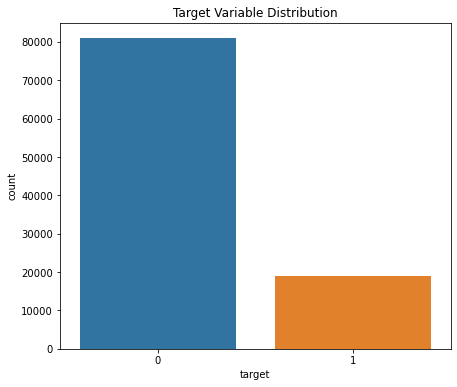

In [11]:
#target variable dist


plt.figure(figsize=(7, 6))
sns.countplot(train_df["target"])
plt.title('Target Variable Distribution');

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import auc, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
import xgboost as xgb

In [13]:
X,y = train_df.iloc[:,:-1],train_df['target']
test_lgb = test_df

<h2>LightGBM</h2>

In [14]:
lgb_params = {'boosting_type': 'gbdt','objective': 'binary','metric': 'auc',
              'n_estimators': 500,'early_stopping_rounds': 100,
              'colsample_bytree' : 0.6,'seed': SEED,
            }
score = 0
test_lgb['target'] = 0
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=SEED)

lgb_result = np.zeros((train_df.shape[0]))
lgb_predictions = []

In [15]:
for f_, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print('Fold:',_+1)
        
    # Creating lgb train/valid data
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx] 
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx] 
        
    train_data = lgb.Dataset(tr_x, label=tr_y,categorical_feature=cat_data)
    valid_data = lgb.Dataset(vl_x, label=vl_y,categorical_feature=cat_data)
    # Train Model
    
    estimator = lgb.train(
                          lgb_params,
                          train_data,
                          valid_sets = [train_data,valid_data],
                          verbose_eval = 100,
                        )

    y_pred_val = estimator.predict(vl_x,num_iteration=estimator.best_iteration)
    lgb_result[val_idx] = y_pred_val
    score = score + roc_auc_score(vl_y, y_pred_val)
    y_pred_test = estimator.predict(test_lgb.iloc[:,:-1],num_iteration=estimator.best_iteration)
    lgb_predictions.append(y_pred_test)

print('lgb score :',roc_auc_score(y, lgb_result))

Fold:    Month  DayofMonth  DayOfWeek  DepTime  UniqueCarrier  Origin  Dest  \
0      9          22          8     1935              1      19    79   
1      5          21          4     1549             19     218   172   
2     10           3          6     1423             21     229    60   
3     12          26          7     1016             16      79   176   
4     11           8          7     1829             20     175   200   
5      9           4          5     1919             14     177   172   
6      2          28          5      755              7     209   158   
7      5          30          7      636             15     194    71   
8      8          29          6      736              1     204    79   
9      7          21          3     2030             16      79   218   

   Distance  target  
0       733       1  
1       835       1  
2       417       1  
3       873       1  
4       424       2  
5       684       1  
6      1036       1  
7       597   

/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridde

[100]	training's auc: 0.839324	valid_1's auc: 0.734763
[200]	training's auc: 0.879145	valid_1's auc: 0.735041
Early stopping, best iteration is:
[124]	training's auc: 0.850289	valid_1's auc: 0.736331
Fold:    Month  DayofMonth  DayOfWeek  DepTime  UniqueCarrier  Origin  Dest  \
0      9          22          8     1935              1      19    79   
1      5          21          4     1549             19     218   172   
2     10           3          6     1423             21     229    60   
3     12          26          7     1016             16      79   176   
4     11           8          7     1829             20     175   200   
5      9           4          5     1919             14     177   172   
6      2          28          5      755              7     209   158   
7      5          30          7      636             15     194    71   
8      8          29          6      736              1     204    79   
9      7          21          3     2030             16      79 

/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridde

[100]	training's auc: 0.839566	valid_1's auc: 0.736132
[200]	training's auc: 0.87916	valid_1's auc: 0.737046
[300]	training's auc: 0.903795	valid_1's auc: 0.73794
Early stopping, best iteration is:
[268]	training's auc: 0.895425	valid_1's auc: 0.738927
Fold:    Month  DayofMonth  DayOfWeek  DepTime  UniqueCarrier  Origin  Dest  \
0      9          22          8     1935              1      19    79   
1      5          21          4     1549             19     218   172   
2     10           3          6     1423             21     229    60   
3     12          26          7     1016             16      79   176   
4     11           8          7     1829             20     175   200   
5      9           4          5     1919             14     177   172   
6      2          28          5      755              7     209   158   
7      5          30          7      636             15     194    71   
8      8          29          6      736              1     204    79   
9      7   

/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridde

[100]	training's auc: 0.8401	valid_1's auc: 0.735243
[200]	training's auc: 0.878765	valid_1's auc: 0.735605
Early stopping, best iteration is:
[187]	training's auc: 0.874211	valid_1's auc: 0.736428
Fold:    Month  DayofMonth  DayOfWeek  DepTime  UniqueCarrier  Origin  Dest  \
0      9          22          8     1935              1      19    79   
1      5          21          4     1549             19     218   172   
2     10           3          6     1423             21     229    60   
3     12          26          7     1016             16      79   176   
4     11           8          7     1829             20     175   200   
5      9           4          5     1919             14     177   172   
6      2          28          5      755              7     209   158   
7      5          30          7      636             15     194    71   
8      8          29          6      736              1     204    79   
9      7          21          3     2030             16      79   

/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridde

[100]	training's auc: 0.838799	valid_1's auc: 0.737418
[200]	training's auc: 0.879937	valid_1's auc: 0.738827
[300]	training's auc: 0.907006	valid_1's auc: 0.739334
[400]	training's auc: 0.928016	valid_1's auc: 0.738934
Early stopping, best iteration is:
[335]	training's auc: 0.914343	valid_1's auc: 0.739923
Fold:    Month  DayofMonth  DayOfWeek  DepTime  UniqueCarrier  Origin  Dest  \
0      9          22          8     1935              1      19    79   
1      5          21          4     1549             19     218   172   
2     10           3          6     1423             21     229    60   
3     12          26          7     1016             16      79   176   
4     11           8          7     1829             20     175   200   
5      9           4          5     1919             14     177   172   
6      2          28          5      755              7     209   158   
7      5          30          7      636             15     194    71   
8      8          29       

/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/hlpc/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridde

[100]	training's auc: 0.838466	valid_1's auc: 0.738975
[200]	training's auc: 0.878013	valid_1's auc: 0.741845
[300]	training's auc: 0.906901	valid_1's auc: 0.743171
[400]	training's auc: 0.929718	valid_1's auc: 0.743694
Early stopping, best iteration is:
[357]	training's auc: 0.921431	valid_1's auc: 0.744433
lgb score : 0.7391032645861788


In [18]:
lightgbm_preds = np.mean(lgb_predictions,axis=0)
roc_auc_score(y,lightgbm_preds)

0.5034912272197274

<h2>Xgboost</h2>

In [23]:
xgb_param = {'objective': 'reg:squarederror','eval_metric': 'auc','subsample': 0.8,'colsample_bytree' : 0.9,'learning_rate':0.02,'random_state':SEED, 'seed':SEED, 'booster': 'gbtree', 'grow_policy':'lossguide'}
score = 0
test_xgb = test_df
test_xgb['target'] = 0
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=SEED)

xgb_result= np.zeros((X.shape[0]))
xgb_predictions = []

In [24]:
score = 0
test_xgb['target'] = 0

for _, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print('Fold:',_+1)
        
    # Creating lgb train/valid data
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx] 
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx] 
        
    train_data = xgb.DMatrix(tr_x, label=tr_y)
    valid_data = xgb.DMatrix(vl_x, label=vl_y)
    ###
    evals=[(train_data, 'train'), (valid_data, 'valid')]
    estimator_clf = xgb.train(xgb_param,train_data,evals=evals,num_boost_round=10000, 
        
        verbose_eval = 100,early_stopping_rounds=100)
    

    y_pred_val = estimator_clf.predict(xgb.DMatrix(vl_x))
    xgb_result[val_idx] = y_pred_val
    score = score + roc_auc_score(vl_y, y_pred_val)
    y_pred_test = estimator_clf.predict(xgb.DMatrix(test_xgb.iloc[:,:-1]))
    xgb_predictions.append(y_pred_test)

print('OOF score :',roc_auc_score(y, xgb_result))

Fold: 1
[0]	train-auc:0.70579	valid-auc:0.69129
[100]	train-auc:0.74242	valid-auc:0.72074
[200]	train-auc:0.76014	valid-auc:0.72959
[300]	train-auc:0.77528	valid-auc:0.73606
[400]	train-auc:0.78721	valid-auc:0.73929
[500]	train-auc:0.79716	valid-auc:0.74206
[600]	train-auc:0.80689	valid-auc:0.74414
[700]	train-auc:0.81524	valid-auc:0.74576
[800]	train-auc:0.82303	valid-auc:0.74701
[900]	train-auc:0.83047	valid-auc:0.74798
[1000]	train-auc:0.83704	valid-auc:0.74846
[1100]	train-auc:0.84376	valid-auc:0.74911
[1200]	train-auc:0.84982	valid-auc:0.74950
[1294]	train-auc:0.85516	valid-auc:0.74941
Fold: 2
[0]	train-auc:0.70353	valid-auc:0.69844
[100]	train-auc:0.74146	valid-auc:0.72311
[200]	train-auc:0.75959	valid-auc:0.73156
[300]	train-auc:0.77425	valid-auc:0.73705
[400]	train-auc:0.78690	valid-auc:0.74096
[500]	train-auc:0.79793	valid-auc:0.74329
[600]	train-auc:0.80726	valid-auc:0.74484
[700]	train-auc:0.81543	valid-auc:0.74628
[800]	train-auc:0.82384	valid-auc:0.74750
[900]	train-auc:0.

In [25]:
xgboost_preds = np.mean(xgb_predictions,axis=0)
roc_auc_score(y,xgboost_preds)


0.5041276058364672

<h2>Decision</h2>
we will choose the xgboost classifier , it gave  high accuracy when i submitted it

In [26]:
submission['dep_delayed_15min'] = xgboost_preds

submission.to_csv('submission.csv',index = False)
submission

,id,dep_delayed_15min
0,0,0.030815
1,1,0.041833
2,2,0.007801
3,3,0.168910
4,4,0.127684
...,...,...
99995,99995,0.028707
99996,99996,0.241811
99997,99997,0.081559
99998,99998,0.070710
